# Assignment 1

Install neccessary libraries

In [34]:
!pip install scikit-learn
!pip install numpy

Import packages

In [35]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


# Dataset
Load the data from sklearn.datasets. For this assignment we are using the Breast Cancer Classification dataset.

In [62]:
breast_cancer = load_breast_cancer()
class_names = breast_cancer.target_names
X_data, y_data = load_breast_cancer(return_X_y=True)

# Partition the dataset into 80/20 split, random seed is 50
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, train_size=0.8, random_state=48)

# Create a dataset with scaled features for the KNN model
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
Create 3 default models and train them on the input data.

In [42]:
# Default is 5 neighbors
knn = KNeighborsClassifier()
knn = knn.fit(X_train_scaled, y_train)

# Default settings
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

# Default has 100 estimators
rand_forest = RandomForestClassifier()
rand_forest = rand_forest.fit(X_train, y_train)

classifiers = [knn, decision_tree, rand_forest]

# Predict on the test
def get_predictions(classifiers):
  return [classifier.predict(X_test_scaled if str(classifier) == "KNeighborsClassifier()" else X_test) for classifier in classifiers]

predictions = get_predictions(classifiers)

Let's take a look at their accuracy on the test set.

In [43]:
def get_metrics(predictions, model_names):
    return pd.DataFrame({
        "Model": model_names,
        "Accuracy": [metrics.accuracy_score(y_test, pred) for pred in predictions],
        "Precision": [metrics.precision_score(y_test, pred) for pred in predictions],
        "Recall": [metrics.recall_score(y_test, pred)  for pred in predictions],
        "F1-Score": [metrics.f1_score(y_test, pred) for pred in predictions],
    })

print(get_metrics(predictions, classifiers))

                                               Model  Accuracy  Precision  \
0                             KNeighborsClassifier()  0.947368   0.957746   
1                           DecisionTreeClassifier()  0.947368   0.957746   
2  (DecisionTreeClassifier(max_features='sqrt', r...  0.964912   0.958904   

     Recall  F1-Score  
0  0.957746  0.957746  
1  0.957746  0.957746  
2  0.985915  0.972222  


# Evaluation
Plot the Confusion Matrices

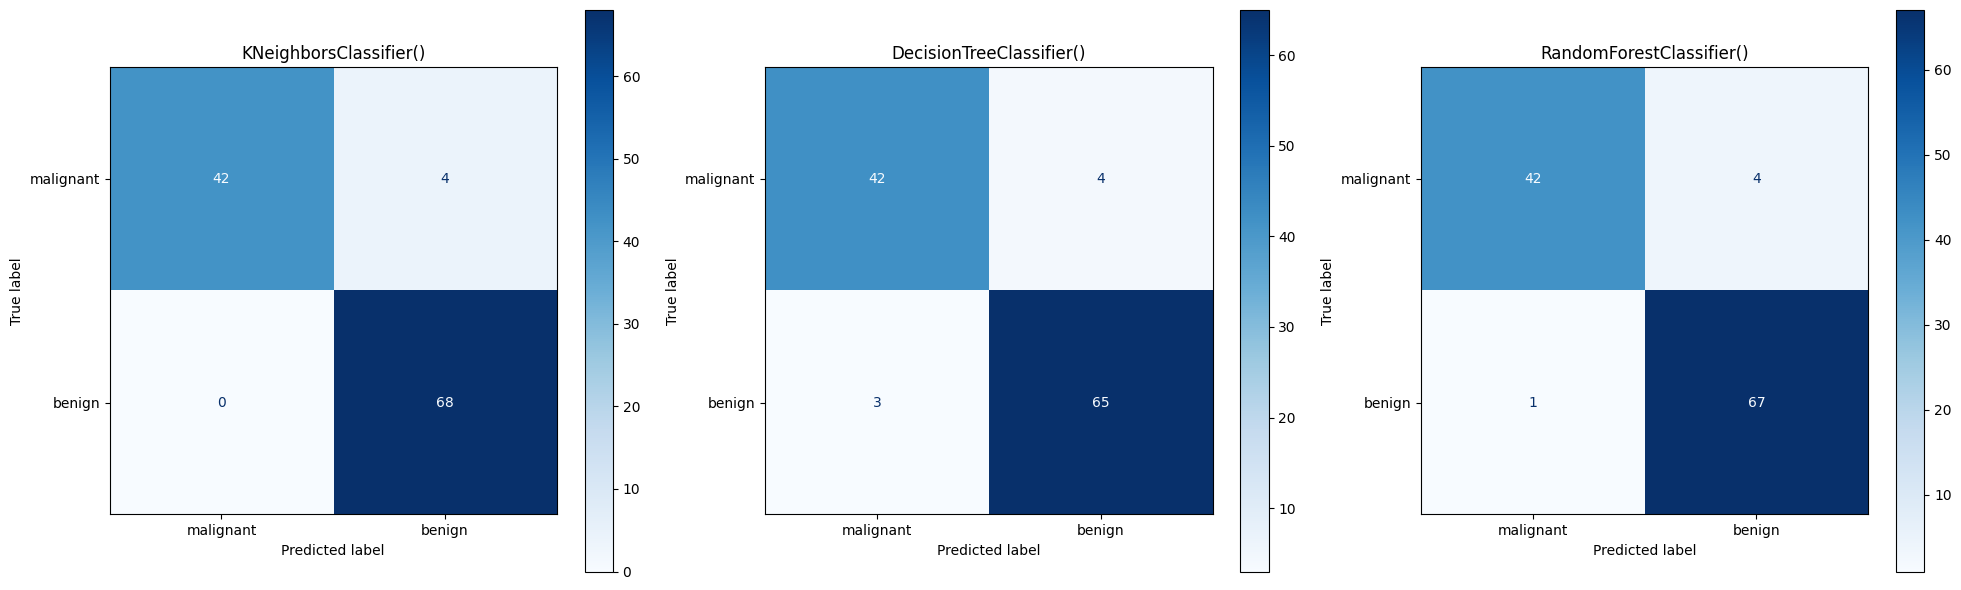

In [68]:
def plot_cm(classifiers, predictions):
    # Calculate the number of classifiers
    num_classifiers = len(classifiers)

    nrows = math.ceil(num_classifiers / 3)
    ncols = 3  # We want 3 classifiers per row

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6 * nrows))
    axs = axs.flatten()

    for i, classifier in enumerate(classifiers):
        y_pred = predictions[i]
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axs[i], cmap=plt.cm.Blues)
        axs[i].set_title(str(classifier))

    # Remove unused subplots (if any) in case classifiers < 3 * nrows
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_cm(classifiers, predictions)


# Ablation Study

Let's modify some key parameters of each model and compare the results

                                                    Model  Accuracy  Precision   Recall  F1-Score
                                                KNN (k=5)  0.964912   0.944444 1.000000  0.971429
                                                KNN (k=1)  0.938596   0.942029 0.955882  0.948905
                                               KNN (k=10)  0.956140   0.943662 0.985294  0.964029
                                               KNN (k=15)  0.938596   0.906667 1.000000  0.951049
                                               KNN (k=20)  0.947368   0.918919 1.000000  0.957746
                               Decision Tree (depth=None)  0.912281   0.939394 0.911765  0.925373
                                  Decision Tree (depth=3)  0.938596   0.969231 0.926471  0.947368
                                  Decision Tree (depth=5)  0.921053   0.940299 0.926471  0.933333
                                 Decision Tree (depth=10)  0.938596   0.955224 0.941176  0.948148
                    

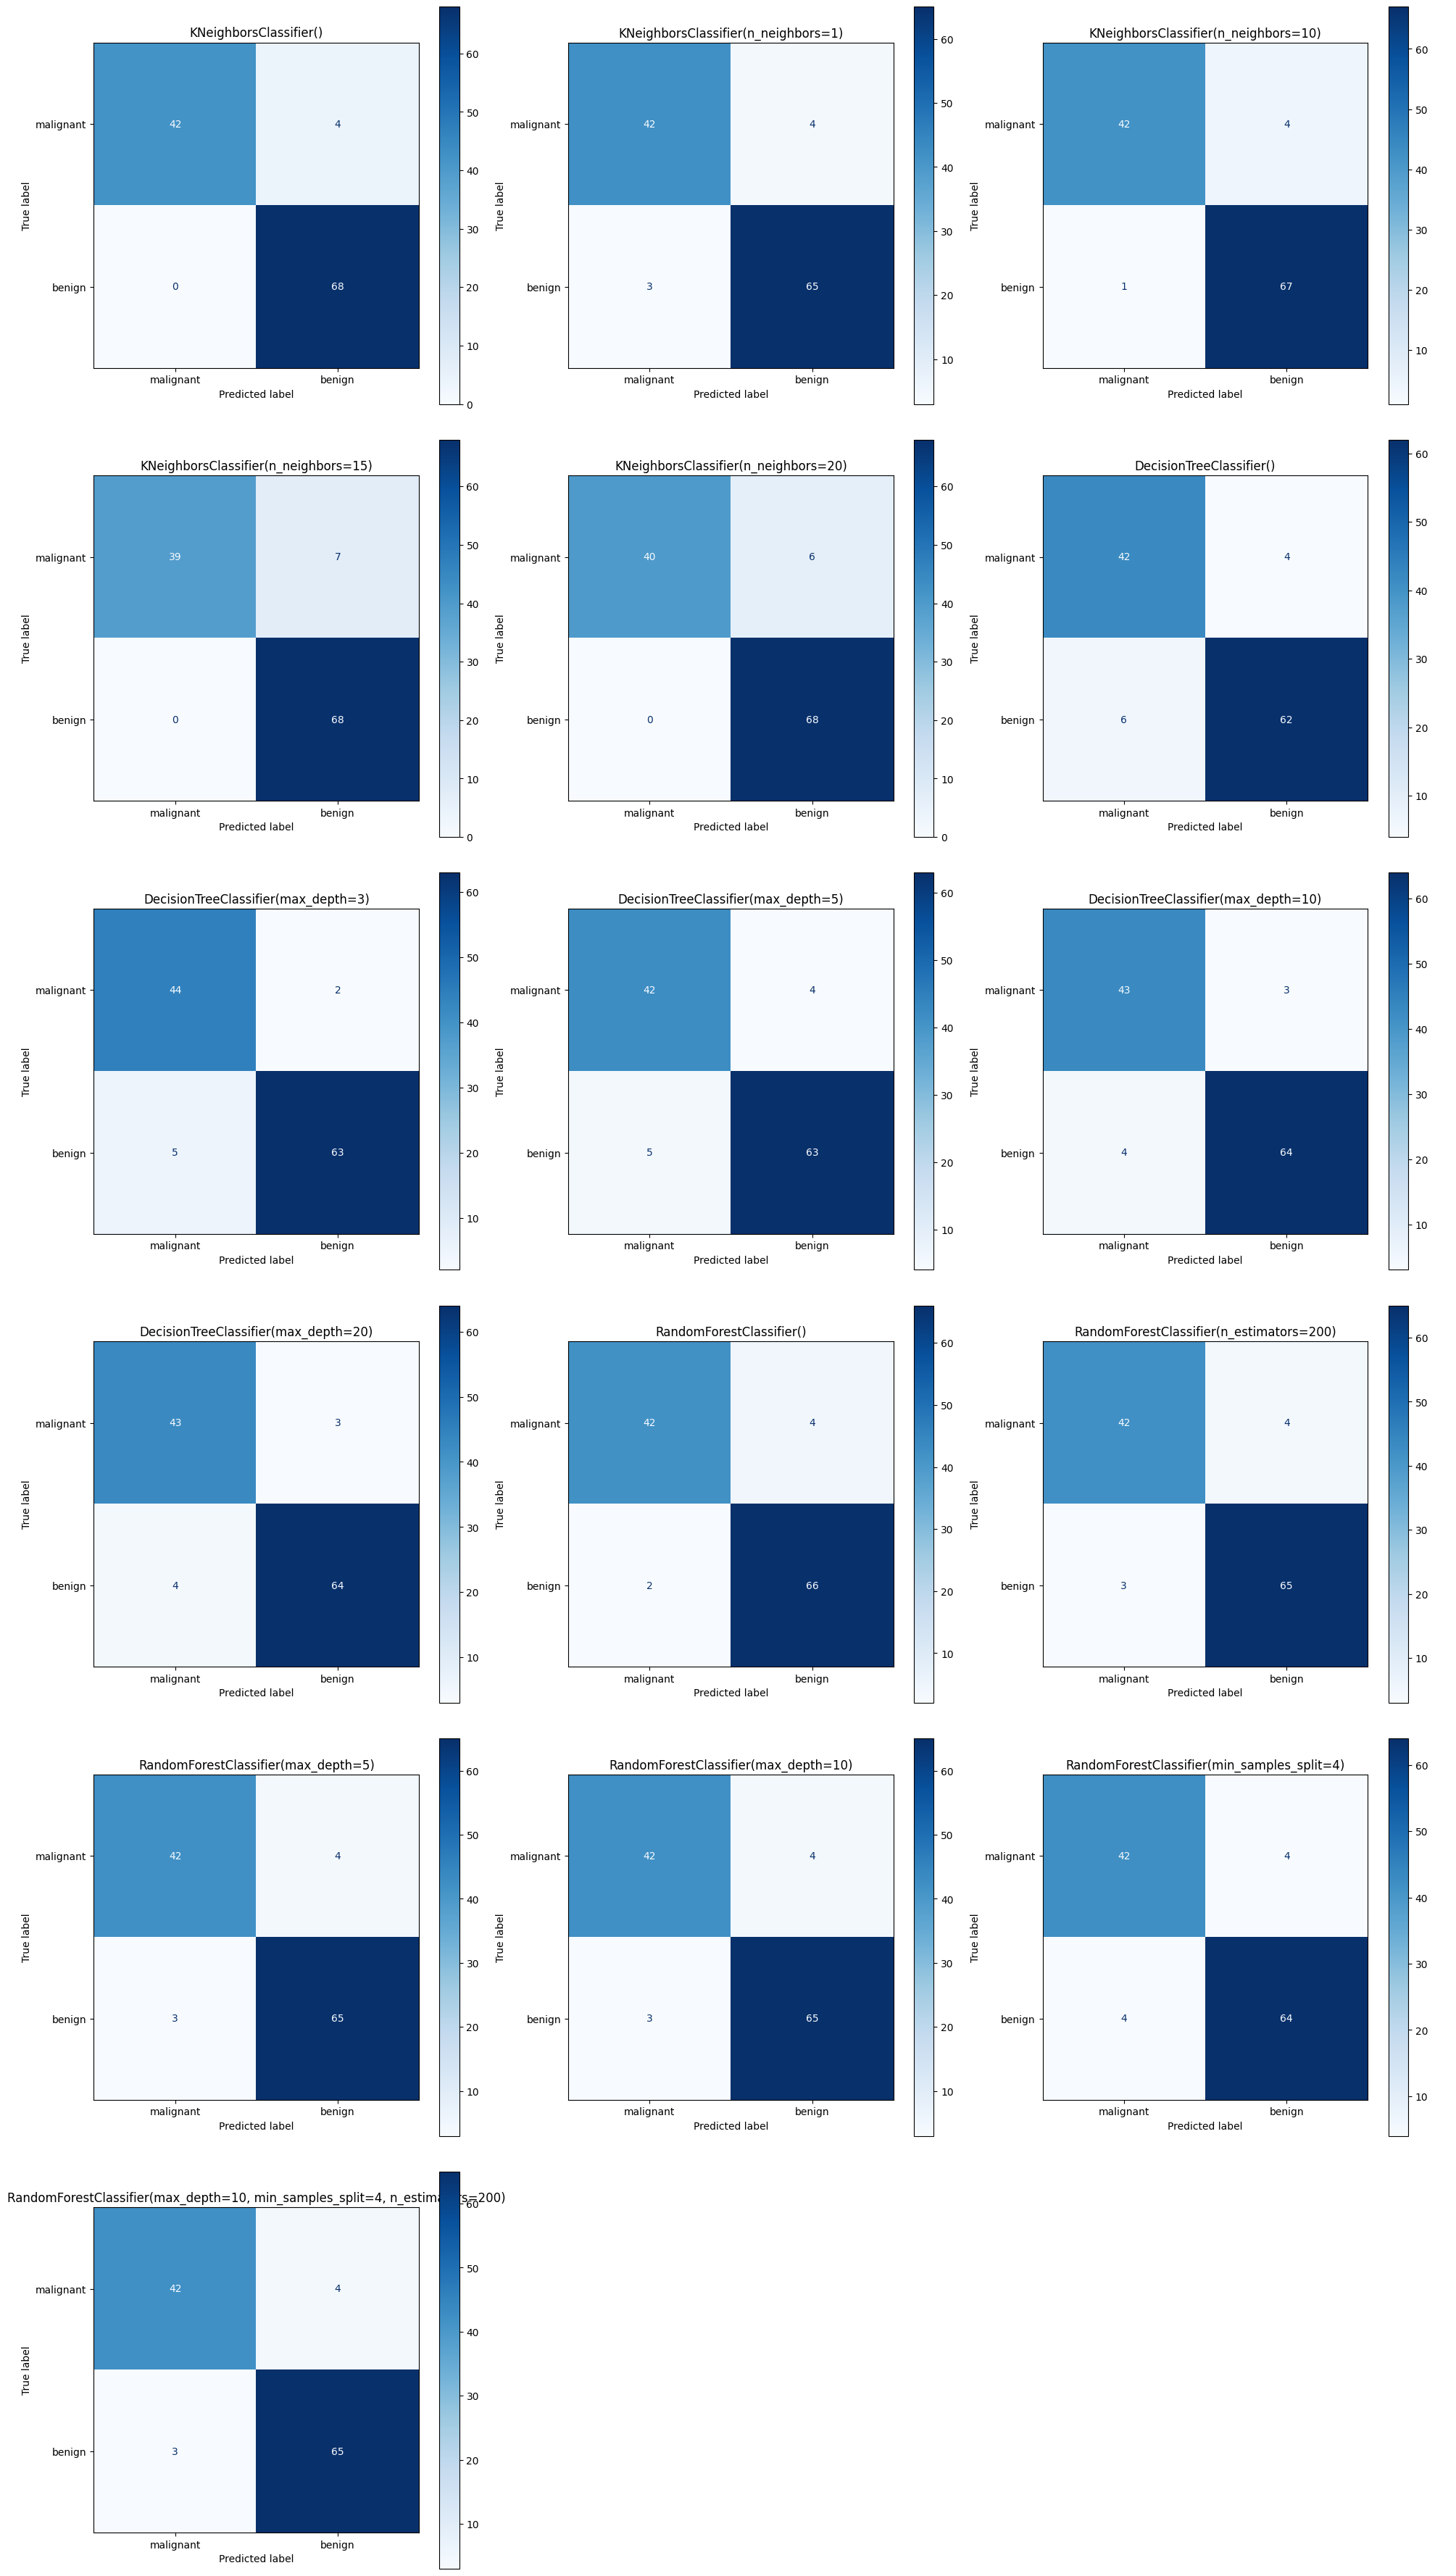

In [69]:
param_grid = {
    "KNN": [5, 1, 10, 15, 20],
    "Decision Tree": [None, 3, 5, 10, 20],
    "Random Forest": [(100, None, 2), (200, None, 2),(100, 5, 2), (100, 10, 2), (100, None, 4), (200, 10, 4)]
}

models = []
model_names = []
predictions = []

for k in param_grid["KNN"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    models.append(knn)
    model_names.append(f"KNN (k={k})")
    predictions.append(knn.predict(X_test_scaled))

for depth in param_grid["Decision Tree"]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    models.append(dt)
    model_names.append(f"Decision Tree (depth={depth})")
    predictions.append(dt.predict(X_test))

for n_estimators, max_depth, min_split in param_grid["Random Forest"]:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_split)
    rf.fit(X_train, y_train)
    models.append(rf)
    model_names.append(f"Random Forest (trees={n_estimators}, depth={max_depth} min_samples_split={min_split})")
    predictions.append(rf.predict(X_test))

# Generate consolidated metrics table
df = get_metrics(predictions, model_names)

# Print final table
print(df.to_string(index=False))

# Print final table in latex for copying and pasting
format = "l" + \
          "@{\hskip 12pt}" +\
          4*"S[table-format = 2.2]"
print(df.to_latex(column_format=format))

# Plot confusion matrices
plot_cm(models, predictions)